## Python Libraries Used Within Workbook

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
import scipy.linalg as la
import scipy.stats as st
import math
import matplotlib
import matplotlib.pyplot as plt

## Background Information
Overfishing of abalone has put them as an endangered species due to their long maturation time. Sexual maturation of abalone is reported to be at 3 years, but reproduction may not occur until a much later time.
<br>

## Project Focus:
Fit a regression line to the provided data to estimate and predict abalone age based on non-destructive physical attributes. 
<br>
Provide reasoning for multivariate techniques as well as assumptions on what makes them valid to use.

## Credentials

Data comes from an original study:

	Warwick J Nash, Tracy L Sellers, Simon R Talbot, Andrew J Cawthorn and
	Wes B Ford (1994) "The Population Biology of Abalone (_Haliotis_
	species) in Tasmania. I. Blacklip Abalone (_H. rubra_) from the North
	Coast and Islands of Bass Strait", Sea Fisheries Division, Technical
	Report No. 48 (ISSN 1034-3288)
    
Original owners of data:
    
	Marine Resources Division
	Marine Research Laboratories - Taroona
	Department of Primary Industry and Fisheries, Tasmania
	GPO Box 619F, Hobart, Tasmania 7001, Australia
	(contact: Warwick Nash +61 02 277277, wnash@dpi.tas.gov.au)

## Cleaning Data

Attribute information:

| Variable  | Data Type | Units | Description |
| :--- | :--- | :--- | :--- |
| Sex | Ordinal |	M, F, I | M = male, F = female, I = infant |
| Length | Continuous |	mm | longest shell measurement |
| Diameter | Continuous | mm | perpendicular to length |
| Height | Continuous | mm | with meat in shell |
| Whole weight | Continuous | grams | whole abalone |
| Shucked weight | Continuous | grams |weight of meat |
| Viscera weight | Continuous | grams | gut weight (after bleeding) |
| Shell weight | Continuous | grams | after being dried |
| Rings | Integer | | +1.5 gives the age in years |

   



In [3]:
# Import the .data file into a dataframe with column headers listed below.
Aba_data = pd.read_csv("abalone.data", names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight','Ring Count'])

#display(Aba_data)

# Next step is to seperate the male, female, and infant abalone data to minimize confounding factors. 
# Invoking the "df.loc" method to return the seperated abalone data based on sex to their new corresponding dataframes.  
Aba_data_male = Aba_data.loc[Aba_data['Sex'] == 'M']
Aba_data_female = Aba_data.loc[Aba_data['Sex'] == 'F']  
Aba_data_inf = Aba_data.loc[Aba_data['Sex'] == 'I']

# Dropping the "Sex" column within their respective dataframes to reduce redundant information.
Aba_data_male = Aba_data_male.drop(['Sex'], axis = 1)
Aba_data_female = Aba_data_female.drop(['Sex'], axis = 1)
Aba_data_inf = Aba_data_inf.drop(['Sex'], axis = 1)

# Resetting index starting at 0 enumerating until the last data point within respective dataframes making sure to not include the old segmented indices.
Aba_data_male = Aba_data_male.reset_index(drop = True)
Aba_data_female = Aba_data_female.reset_index(drop = True)
Aba_data_inf = Aba_data_inf.reset_index(drop = True)

# Non-destructive measurements are length, height, diameter, and weight. Removing the shucked, viscera, and shell weight data.
# Keeping the ring count as response variable.
Aba_data_male = Aba_data_male.drop(['Shucked Weight', 'Viscera Weight', 'Shell Weight'], axis = 1)
Aba_data_female = Aba_data_female.drop(['Shucked Weight', 'Viscera Weight', 'Shell Weight'], axis = 1)
Aba_data_inf = Aba_data_inf.drop(['Shucked Weight', 'Viscera Weight', 'Shell Weight'], axis = 1)

display(Aba_data_male, Aba_data_female, Aba_data_inf)


,Length,Diameter,Height,Whole Weight,Ring Count
0,0.455,0.365,0.095,0.5140,15
1,0.350,0.265,0.090,0.2255,7
2,0.440,0.365,0.125,0.5160,10
3,0.475,0.370,0.125,0.5095,9
4,0.430,0.350,0.110,0.4060,10
...,...,...,...,...,...
1523,0.550,0.430,0.130,0.8395,10
1524,0.560,0.430,0.155,0.8675,8
1525,0.590,0.440,0.135,0.9660,10
1526,0.600,0.475,0.205,1.1760,9


,Length,Diameter,Height,Whole Weight,Ring Count
0,0.530,0.420,0.135,0.6770,9
1,0.530,0.415,0.150,0.7775,20
2,0.545,0.425,0.125,0.7680,16
3,0.550,0.440,0.150,0.8945,19
4,0.525,0.380,0.140,0.6065,14
...,...,...,...,...,...
1302,0.585,0.475,0.165,1.0530,11
1303,0.585,0.455,0.170,0.9945,11
1304,0.515,0.400,0.125,0.6150,8
1305,0.565,0.450,0.165,0.8870,11


,Length,Diameter,Height,Whole Weight,Ring Count
0,0.330,0.255,0.080,0.2050,7
1,0.425,0.300,0.095,0.3515,8
2,0.355,0.280,0.085,0.2905,7
3,0.380,0.275,0.100,0.2255,10
4,0.240,0.175,0.045,0.0700,5
...,...,...,...,...,...
1337,0.480,0.355,0.110,0.4495,8
1338,0.390,0.310,0.085,0.3440,7
1339,0.390,0.290,0.100,0.2845,7
1340,0.405,0.300,0.085,0.3035,7


## Descriptive Statistics for Length, Diameter, Height, Whole Weight, and Ring Count

Calculate sample mean, sample variance, interquartile range, and correlation coefficient for physical attribute variables.

In [4]:
# To calculate the descriptive statistics and more, the number of observations is needed. Here I'm invoking the "len(df)" method on each dataframe to their respective number of observations.
n_male = len(Aba_data_male)
n_female = len(Aba_data_female)
n_inf = len(Aba_data_inf)

print(n_male, n_female, n_inf) 

1528 1307 1342


#### Sample Mean for Length, Diameter, Height, Whole Weight, and Ring Count.

In [5]:
# Incredibly easy method to invoke is the "df.mean()".
# Returns the mean of each column as a Panda Series.
Aba_data_male_mean = Aba_data_male.mean(axis = 0)
Aba_data_female_mean = Aba_data_female.mean(axis = 0)
Aba_data_inf_mean = Aba_data_inf.mean(axis = 0)

display(Aba_data_male_mean, Aba_data_female_mean, Aba_data_inf_mean) 


Length           0.561391
Diameter         0.439287
Height           0.151381
Whole Weight     0.991459
Ring Count      10.705497
dtype: float64

Length           0.579093
Diameter         0.454732
Height           0.158011
Whole Weight     1.046532
Ring Count      11.129304
dtype: float64

Length          0.427746
Diameter        0.326494
Height          0.107996
Whole Weight    0.431363
Ring Count      7.890462
dtype: float64

#### Sample standard deviation for Length, Diameter, Height, Whole Weight, and Ring Count.

In [6]:
# Using a similar method but for standard deviation, "df.std()".
Aba_data_male_std = Aba_data_male.std(axis = 0)
Aba_data_female_std = Aba_data_female.std(axis = 0)
Aba_data_inf_std = Aba_data_inf.std(axis = 0)

display(Aba_data_male_std, Aba_data_female_std, Aba_data_inf_std) 

Length          0.102697
Diameter        0.084398
Height          0.034804
Whole Weight    0.470581
Ring Count      3.026349
dtype: float64

Length          0.086160
Diameter        0.070954
Height          0.039984
Whole Weight    0.430316
Ring Count      3.104256
dtype: float64

Length          0.108858
Diameter        0.088109
Height          0.031995
Whole Weight    0.286275
Ring Count      2.511554
dtype: float64

#### Sample variance for Length, Diameter, Height, Whole Weight, and Ring Count.

In [7]:
# I already have the standard deviation for each variable, squaring them will provide me with the sample variances as well.
# I'm invoking the numpy power method that passes in a series or list and raises all the entries to the second power.
Aba_data_male_var = np.power(Aba_data_male_std, 2)
Aba_data_female_var = np.power(Aba_data_female_std, 2)
Aba_data_inf_var = np.power(Aba_data_inf_std, 2)

display(Aba_data_male_var, Aba_data_female_var, Aba_data_inf_var )

Length          0.010547
Diameter        0.007123
Height          0.001211
Whole Weight    0.221447
Ring Count      9.158791
dtype: float64

Length          0.007423
Diameter        0.005034
Height          0.001599
Whole Weight    0.185172
Ring Count      9.636407
dtype: float64

Length          0.011850
Diameter        0.007763
Height          0.001024
Whole Weight    0.081953
Ring Count      6.307903
dtype: float64

#### First Quartile, Median (Second Quartile), Third Quartile, and Interquartile Range with Outliers.

In [8]:
# There are a few ways to calculate the quartiles, but I'm going to use a method that inputs a percentile.
# Reminder that the first quartile is the 25th percentile; similarly for the second and third corresponds to the 50th and 75th percentile.
q1_male = np.percentile(Aba_data_male['Length'], q = 50, axis = 0, interpolation = 'midpoint')

# Here I'm creating a summary table for the quartiles, interquartile range, minimum (Q1-1.5*IQR), maximum (Q3+1.5*IQR).
qrt_male = pd.DataFrame(index = ['Q1', 'Q2', 'Q3', 'IQR',  'Minimum', 'Maximum'], columns = Aba_data_male.columns)
qrt_female = pd.DataFrame(index = ['Q1', 'Q2', 'Q3', 'IQR', 'Minimum', 'Maximum'], columns = Aba_data_male.columns)
qrt_inf = pd.DataFrame(index = ['Q1', 'Q2', 'Q3', 'IQR', 'Minimum', 'Maximum'], columns = Aba_data_male.columns)


# Extracting header from the male abalone data column headers that can be used for quartile summary algorithm.
var_list = list(Aba_data_male.columns)

# Percentile values list.
pct_list = [('Q1', 25), ('Q2', 50), ('Q3', 75), ('Minimum', 0), ('Maximum', 100)]

# Looping through the columns of each abalone dataframe computing the Q1, Q2, Q3, %Pct-Minimum, and %Pct-Maximum.
# I'm defining the %Pct-Min, Max as the 0th percentile and 100th percentile.
for var in var_list:
    for qrt, pct in pct_list:
       
        qrt_male_val = np.percentile(Aba_data_male[var], q = int(pct), axis = 0, interpolation = 'midpoint')
        qrt_male.loc[qrt, var] = qrt_male_val
        
        qrt_female_val = np.percentile(Aba_data_female[var], q = int(pct), axis = 0, interpolation = 'midpoint')
        qrt_female.loc[qrt, var] = qrt_female_val
        
        qrt_inf_val = np.percentile(Aba_data_inf[var], q = int(pct), axis = 0, interpolation = 'midpoint')
        qrt_inf.loc[qrt, var] = qrt_inf_val     

# Computing interquartile range. 
for var in var_list:
    qrt_male.loc['IQR', var] = qrt_male.loc['Q3', var] - qrt_male.loc['Q1', var]
    qrt_female.loc['IQR', var] = qrt_female.loc['Q3', var] - qrt_female.loc['Q1', var]
    qrt_inf.loc['IQR', var] = qrt_inf.loc['Q3', var] - qrt_inf.loc['Q1', var]

display(qrt_male, qrt_female, qrt_inf,)

,Length,Diameter,Height,Whole Weight,Ring Count
Q1,0.505,0.395,0.13,0.67075,9
Q2,0.58,0.455,0.155,0.97575,10
Q3,0.63,0.5,0.175,1.26575,12
IQR,0.125,0.105,0.045,0.595,3
Minimum,0.155,0.11,0.025,0.0155,3
Maximum,0.78,0.63,0.515,2.8255,27


,Length,Diameter,Height,Whole Weight,Ring Count
Q1,0.525,0.41,0.14,0.73,9
Q2,0.59,0.465,0.16,1.0385,10
Q3,0.64,0.505,0.175,1.32025,12
IQR,0.115,0.095,0.035,0.59025,3
Minimum,0.275,0.195,0.015,0.08,5
Maximum,0.815,0.65,1.13,2.657,29


,Length,Diameter,Height,Whole Weight,Ring Count
Q1,0.36,0.27,0.085,0.2055,6
Q2,0.435,0.335,0.11,0.384,8
Q3,0.51,0.39,0.13,0.59925,9
IQR,0.15,0.12,0.045,0.39375,3
Minimum,0.075,0.055,0,0.002,1
Maximum,0.725,0.55,0.22,2.0495,21


#### Male Abalone Physical Attributes Boxplots

{'whiskers': [<matplotlib.lines.Line2D at 0x1fdd8410a48>,
 'caps': [<matplotlib.lines.Line2D at 0x1fdd8486948>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fdd8410c48>],
 'medians': [<matplotlib.lines.Line2D at 0x1fdd848be08>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fdd848b908>],
 'means': []}

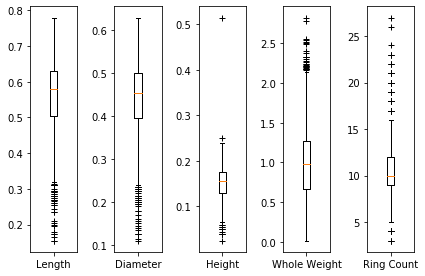

In [9]:
# Place 5 plots for each variable. 
fig, axs = plt.subplots(1, 5)

#fig = plt.figure(figsize = (6, 3))

# Improve spacing of boxplots using the method below.
fig.tight_layout()

# Converting columns within the male abalone data to list.
len_male = Aba_data_male['Length'].tolist()
dia_male = Aba_data_male['Diameter'].tolist()
ht_male = Aba_data_male['Height'].tolist()
wt_male = Aba_data_male['Whole Weight'].tolist()
ring_male = Aba_data_male['Ring Count'].tolist()

axs[0].boxplot(len_male, 0, 'k+', showfliers = True, labels = ['Length'])
axs[1].boxplot(dia_male, 0, 'k+', showfliers = True, labels = ['Diameter'])
axs[2].boxplot(ht_male, 0, 'k+', showfliers = True, labels = ['Height'])
axs[3].boxplot(wt_male, 0, 'k+', showfliers = True, labels = ['Whole Weight'])
axs[4].boxplot(ring_male, 0, 'k+', showfliers = True, labels = ['Ring Count'])

#### Female Abalone Physical Attributes Boxplots

{'whiskers': [<matplotlib.lines.Line2D at 0x1fdd87212c8>,
 'caps': [<matplotlib.lines.Line2D at 0x1fdd8731e08>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fdd87074c8>],
 'medians': [<matplotlib.lines.Line2D at 0x1fdd87365c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fdd8736fc8>],
 'means': []}

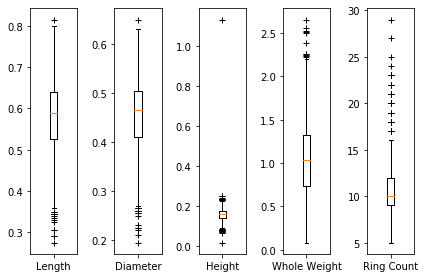

In [10]:
# Place 5 plots for each variable. 
fig, axs = plt.subplots(1, 5)

# Improve spacing of boxplots using the method below.
fig.tight_layout()

# Converting columns within the female abalone data to list.
len_female = Aba_data_female['Length'].tolist()
dia_female = Aba_data_female['Diameter'].tolist()
ht_female = Aba_data_female['Height'].tolist()
wt_female = Aba_data_female['Whole Weight'].tolist()
ring_female = Aba_data_female['Ring Count'].tolist()

axs[0].boxplot(len_female, 0, 'k+', showfliers = True, labels = ['Length'])
axs[1].boxplot(dia_female, 0, 'k+', showfliers = True, labels = ['Diameter'])
axs[2].boxplot(ht_female, 0, 'k+', showfliers = True, labels = ['Height'])
axs[3].boxplot(wt_female, 0, 'k+', showfliers = True, labels = ['Whole Weight'])
axs[4].boxplot(ring_female, 0, 'k+', showfliers = True, labels = ['Ring Count'])

#### Infant Abalone Physical Attributes Boxplots

{'whiskers': [<matplotlib.lines.Line2D at 0x1fdd8911ac8>,
 'caps': [<matplotlib.lines.Line2D at 0x1fdd8949e88>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fdd88cb288>],
 'medians': [<matplotlib.lines.Line2D at 0x1fdd8955388>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fdd8955d88>],
 'means': []}

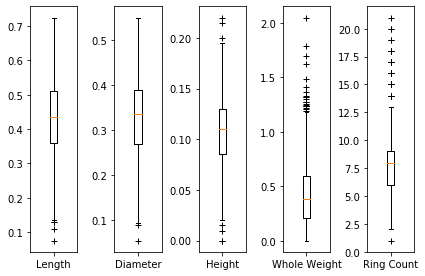

In [11]:
# Place 5 plots for each variable. 
fig, axs = plt.subplots(1, 5)

# Improve spacing of boxplots using the method below.
fig.tight_layout()

# Converting columns within the infant abalone data to list.
len_inf = Aba_data_inf['Length'].tolist()
dia_inf = Aba_data_inf['Diameter'].tolist()
ht_inf = Aba_data_inf['Height'].tolist()
wt_inf = Aba_data_inf['Whole Weight'].tolist()
ring_inf = Aba_data_inf['Ring Count'].tolist()

axs[0].boxplot(len_inf, 0,'k+', showfliers = True, labels = ['Length'])
axs[1].boxplot(dia_inf, 0,'k+', showfliers = True, labels = ['Diameter'])
axs[2].boxplot(ht_inf, 0,'k+', showfliers = True, labels = ['Height'])
axs[3].boxplot(wt_inf, 0,'k+', showfliers = True, labels = ['Whole Weight'])
axs[4].boxplot(ring_inf, 0,'k+', showfliers = True, labels = ['Ring Count'])

Inspecting the 5 number summary tables for the infant abalone, the ring count stands out as odd. According to the 128th fisheries report published in 2001 by the Australian Department of Fisheries, black lip abalone has a maturation age of 3 years. The ring count boxplot for the infant data shows spread from 1 to over 20 rings with half of the data between 6 to 9 rings. The age computed with ring count is ring count add 1.5. Working backwards here starting with age to ring count, a mature black lip abalone is 1.5 rings. Destructive methods and an additional study would need to be undertaken to estimate age on width between rings, so I will conservatively round down on ring count making an infant black lip abalone having less than 2 rings.

<br>
Using the biology of the abalone as justification, I will discard observations within the infant dataframe with less than 2 rings.

In [12]:
display(Aba_data_inf[Aba_data_inf['Ring Count'] < 2])

,Length,Diameter,Height,Whole Weight,Ring Count
39,0.075,0.055,0.01,0.002,1


The returned dataframe for infant abalone with a conditional operator for less than 2 ring count contains a singular entry. There is something suspicious about this data set or my understanding of the "infant" designation is flawed. I will rely on the biology as a foundation for decision making in this case and not use the infant data set.
<br>

I would like to now combine the female and male abalone data into one for a single regression analysis, but is that appropriate to do so? Is there a statistical tool to examine if female abalone are different enough from male abalone in terms of physical features requiring two seperate regressions?
<br>

A test of two population means comes to mind with the assumption of unequal variances to determine if male and female abalone physical features are different from each other. I'll be using a non-pooled t-Test with the assumptions that the abalones were simple randomly selected and that the selection of abalone were independent of previous choices. With the practical application of the Central Limit Theorem, and a healthy sample size of one thousand plus, the normal assumption is fulfilled.

#### Non-Pooled t-Test

The null hypothesis: mean male abalone physical feature is equal to that of their female counterpoint.
<br>
The alternative hypothesis: mean male abalone physical feature is not equal to that of their female counterpoint.
<br> 

Alpha-level = 5%
<br>

If p-value <= Alpha-level, reject null hypothesis.

In [21]:
tt_results = pd.DataFrame(index = var_list, columns = ['t-Statistic', 'p-value'])

for var in var_list:
    t_stat, p_val = st.ttest_ind(Aba_data_male[var], Aba_data_female[var], equal_var = False)
    tt_results.loc[var] = t_stat, p_val

display(tt_results)

,t-Statistic,p-value
Length,-4.9907,6.38015e-07
Diameter,-5.29354,1.29146e-07
Height,-4.66939,3.17388e-06
Whole Weight,-3.25309,0.00115504
Ring Count,-3.66566,0.000251381


The table summarizes the t-Statistic, and p-values for the physical features. The returned p-values say to reject the null hypothesis for all features; simply said, female abalone differ in size and age from males.
<br>
With the information provided so far, I will run a regression on male, female abalone seperately, and a regression on a combined data set.

#### Variable Correlation by Sex

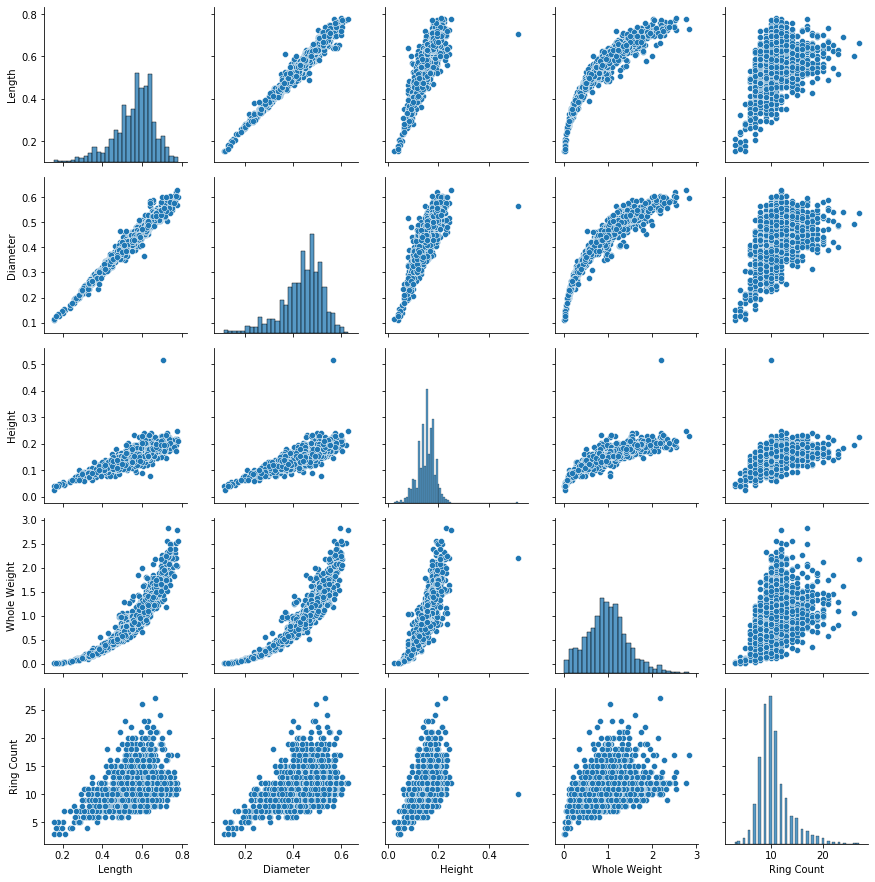

In [25]:
# PairGrid method is used to quickly assess relationships among the variables by way of scatter plots.
pgs_male = sns.PairGrid(Aba_data_male)
pgs_male.map_diag(sns.histplot)
pgs_male.map_offdiag(sns.scatterplot)

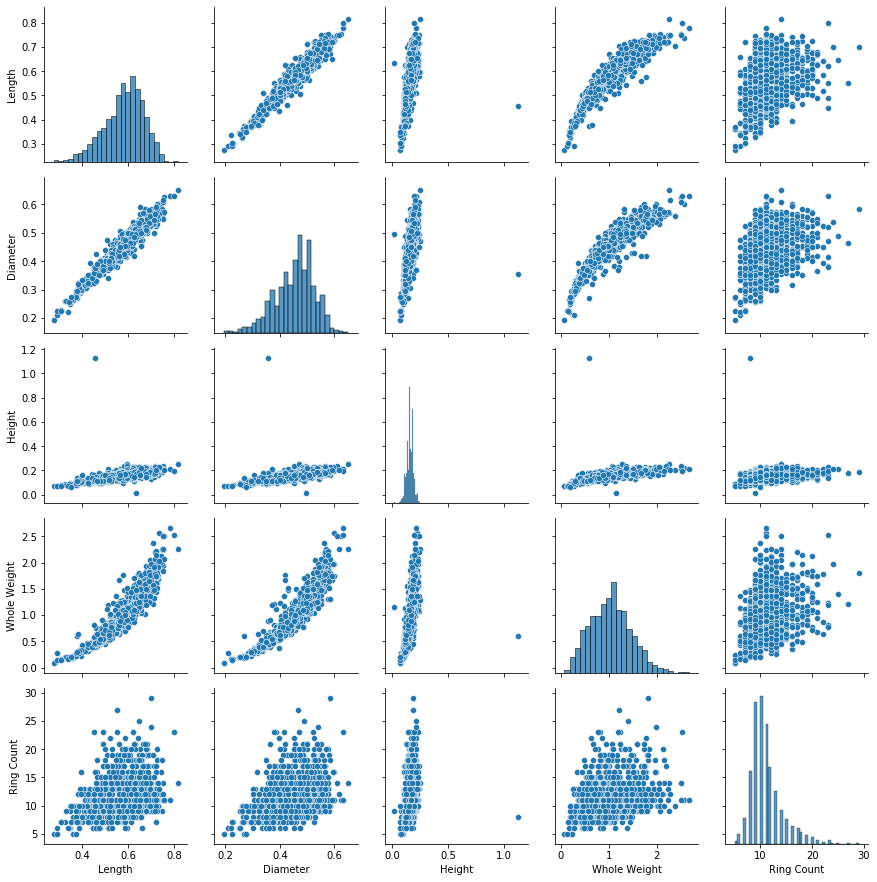

In [24]:
pgs_female = sns.PairGrid(Aba_data_female)
pgs_female.map_diag(sns.histplot)
pgs_female.map_offdiag(sns.scatterplot)